# import packages

In [2]:
import rmsp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

import sys
sys.path.append('../python_modules/')  # Defining the path to my modules
from hyperparameter_tunning import RandomSearch_KF, GridSearch_KF
from conditional_distributions import ConditionalMG, ConditionalML
from evaluation import AccuracyEvaluator

# load data

In [3]:
# Loading data as we would with a "real" csv file
data = pd.read_csv('wl_semisyn_bivariate.csv')
# data_orig['z'] = 0

# Converting Pandas Dataframe into a RMSP Point Data
data = rmsp.PointData(data, x='x', y="y")
data.drop('x1_shift', axis=1, inplace=True)
data.rename(columns={'x1':'var1', 'tg':'var2'}, inplace=True)

type(data)

rmsp.core.point.PointData

# sub-sampling and splitting data

In [4]:
# Define threshold on the reference variable
thr_var = 'var1'
threshold = data[thr_var].quantile(0.50)

# fractions to select as "complete"
frac_above = 0.60
frac_below = 0.40

# Select samples above and below the median threshold
samples_above_threshold = data[data[thr_var] > threshold]
samples_below_threshold = data[(data[thr_var] < threshold)]

# Sample subsets
complete_set_above = samples_above_threshold.sample(frac=frac_above, random_state=42)
complete_set_below = samples_below_threshold.sample(frac=frac_below, random_state=42)

# Combine subsets
complete_set = pd.concat([complete_set_above, complete_set_below])

# Remaining samples (excluding complete set) go to missing set
missing_set = data.drop(complete_set.index)

# Split the "complete" subset into validation and modeling subsets
valid_set = complete_set.sample(frac=0.15, random_state=42)
model_set = complete_set.drop(valid_set.index)

# Create flags in the main dataframe
data['missing'] = 0
data['valid'] = 0
data['model'] = 0
data.loc[missing_set.index, 'missing'] = 1
data.loc[valid_set.index,   'valid']   = 1
data.loc[model_set.index,   'model']   = 1

In [4]:
model_set = df[df['model'] == 1][['x', 'y', 'x1', 'tg']]
valid_set = df[df['valid'] == 1][['x', 'y', 'x1', 'tg']]
missing_set = df[df['missing'] == 1][['x', 'y', 'x1', 'var2']].rename(columns={'var2':'tg'})
complete_set = df[df['missing'] == 0][['x', 'y', 'x1', 'var2']].rename(columns={'var2':'tg'})

# nscore

In [8]:
# Instantiate transformers
nscorer_var1 = rmsp.NSTransformer(warn_no_wt=False)
nscorer_var2 = rmsp.NSTransformer(warn_no_wt=False)

# Fit and transform predictor
nscorer_var1.fit(model_set['var1'], tail_values=(None, 7.58))
complete_set['ns_var1'] = nscorer_var1.transform(complete_set['var1'])
missing_set['ns_var1'] = nscorer_var1.transform(missing_set['var1'])

# Fit and transform target
nscorer_var2.fit(complete_set['var2'], tail_values=(0.92, 4.84))
complete_set['ns_var2'] = nscorer_var2.transform(complete_set['var2'])
missing_set['ns_var2'] = nscorer_var2.transform(missing_set['var2'])

In [9]:
missing_set

,x,y,var1,var2,ns_var1,ns_var2
1,10.0,1.0,3.541236,3.309053,-1.459462,-1.116824
2,20.0,1.0,2.452675,1.763755,-2.449687,-2.261487
5,50.0,1.0,5.091249,4.260121,-0.153540,0.395290
6,60.0,1.0,5.555451,4.337155,0.386369,0.695289
8,80.0,1.0,5.610309,4.277357,0.439372,0.449051
...,...,...,...,...,...,...
827,170.0,300.0,3.059212,2.658822,-2.004994,-1.607768
829,190.0,300.0,3.592878,3.597003,-1.423365,-0.809603
830,200.0,300.0,3.612507,3.437548,-1.398351,-1.009624
834,240.0,300.0,3.831457,3.841583,-1.211317,-0.504705


In [10]:
complete_set

,x,y,var1,var2,ns_var1,ns_var2
570,30.0,210.0,5.591405,4.104241,0.413073,-0.110051
573,60.0,210.0,6.005198,4.519560,0.952497,1.526866
708,60.0,260.0,5.246342,4.602704,0.007061,1.848063
95,140.0,30.0,5.420090,4.429589,0.213437,1.101096
259,160.0,90.0,6.593295,3.273503,1.598827,-1.159110
...,...,...,...,...,...,...
134,260.0,40.0,4.717806,4.067376,-0.470300,-0.208068
281,110.0,100.0,4.747503,4.367635,-0.440275,0.792225
501,150.0,180.0,4.493520,4.194122,-0.624355,0.177560
483,240.0,170.0,4.410424,3.721562,-0.689803,-0.622683


# fit the model

In [11]:
# Create model instance
model_mg = ConditionalMG()

# fitting
model_mg.fit(complete_set[['ns_var1']].values, complete_set['ns_var2'].values)

# Predicting missing data
means_mg, _, _ = model_mg.predict(missing_set['ns_var1'].values)

# Checking
mse_mg = mean_squared_error(missing_set['ns_var2'].values, means_mg)
rmse_mg = np.sqrt(mse_mg)
r2_mg = r2_score(missing_set['ns_var2'].values, means_mg)

# Printing results
print(f'RMSE calculated on missing data: {np.round(rmse_mg, 4)}')
print(f'R2 calculated on missing data: {np.round(r2_mg, 4)}')

RMSE calculated on missing data: 1.1137
R2 calculated on missing data: -0.0064


In [12]:
# Create model instance
model_ml = ConditionalML(
    regressor=GradientBoostingRegressor,
    r_squared=0.7275,
    reg_hyperparams={'alpha': 0.9,
                     'ccp_alpha': 0.0,
                     'criterion': 'friedman_mse',
                     'init': None,
                     'learning_rate': 0.05,
                     'loss': 'squared_error',
                     'max_depth': 2,
                     'max_features': None,
                     'max_leaf_nodes': None,
                     'min_impurity_decrease': 0.0,
                     'min_samples_leaf': 4,
                     'min_samples_split': 4,
                     'min_weight_fraction_leaf': 0.0,
                     'n_estimators': 100,
                     'n_iter_no_change': None,
                     'random_state': 42,
                     'subsample': 0.8,
                     'tol': 0.0001,
                     'validation_fraction': 0.1,
                     'verbose': 0,
                     'warm_start': False}
)

# fitting
model_ml.fit(complete_set[['ns_var1']].values, complete_set['ns_var2'].values)

# Predicting training data
means_ml, variances_ml, quantiles_ml, _, _ = model_ml.predict(missing_set[['ns_var1']].values, return_pdf=True)

# Checking
mse_ml = mean_squared_error(missing_set['ns_var2'].values, means_ml)
rmse_ml = np.sqrt(mse_ml)
r2_ml = r2_score(missing_set['ns_var2'].values, means_ml)

# Printing results
print(f'RMSE calculated on missing data: {np.round(rmse_ml, 4)}')
print(f'R2 calculated on missing data: {np.round(r2_ml, 4)}')

RMSE calculated on missing data: 0.5696
R2 calculated on missing data: 0.7368


# simulating

In [13]:
def ml_impute(complete_set, missing_set, var_x_ns, var_y_ns, model_ml, n_realizations=1):
    realizations = []

    # start realization
    for r in range(n_realizations):
        print(f"Generating realization {r + 1}")
        path = np.random.permutation(len(missing_set)) # define (random) visiting path for each realization
        
        cond_set = complete_set.copy() # define original conditioning set (containing only the true samples)
        sim_vals = np.full(len(missing_set), np.nan) # start empty array to store values to be simulated
        
        # start generating values for each realization
        for i in range(len(path)): # loop over the elements in "path" to simulate one point at a time
            idx = path[i] # idx is the index of the point being simulated

            target = missing_set.iloc[[idx]]  # refer to specific row in the target dataframe (Must be a DataFrame for kriging)
        
            # Fit ml model using the conditioning set
            model_ml.fit(cond_set[var_x_ns].values, cond_set[var_y_ns].values)
            
            # Estimate conditional mean and variance via ml only on the target point
            mean_arr_ml, var_arr_ml, _ = model_ml.predict(target[var_x_ns].values, return_pdf=False)

            # Retrieve ml predicted results for that target            
            mean_ml = mean_arr_ml[0] # get the predicted ml value
            variance_ml = var_arr_ml[0] # get the predicted ml variance        
            
            #  Draw from N(mean, variance)
            simulated_value = np.random.normal(mean_ml, np.sqrt(variance_ml)) # draw from the conditional distribution
            sim_vals[idx] = simulated_value # record drawn value on the realization's array
            
            # Add simulated point to conditioning set
            new_point = target.copy() # refer to the row being simulated
            new_point[var_y_ns] = simulated_value # recording simulated value on that row
            cond_set = pd.concat([cond_set, new_point], ignore_index=True) # merging new simulated value on the ocnditioning set

        realizations.append(sim_vals) # append simulated values in that realization in the results array

    return np.array(realizations)


In [14]:
import time
start_time = time.time()
n_real = 100
impute_realizations = ml_impute(complete_set, missing_set, ['ns_var1'], 'ns_var2', model_ml, n_realizations=n_real)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Elapsed time: {np.round(elapsed_time / 60, 2)} min.')

Generating realization 1
Generating realization 2
Generating realization 3
Generating realization 4
Generating realization 5
Generating realization 6
Generating realization 7
Generating realization 8
Generating realization 9
Generating realization 10
Generating realization 11
Generating realization 12
Generating realization 13
Generating realization 14
Generating realization 15
Generating realization 16
Generating realization 17
Generating realization 18
Generating realization 19
Generating realization 20
Generating realization 21
Generating realization 22
Generating realization 23
Generating realization 24
Generating realization 25
Generating realization 26
Generating realization 27
Generating realization 28
Generating realization 29
Generating realization 30
Generating realization 31
Generating realization 32
Generating realization 33
Generating realization 34
Generating realization 35
Generating realization 36
Generating realization 37
Generating realization 38
Generating realizatio

## back-transform

In [16]:
# Backtransformation transform
impute_realizations_orig = np.array([nscorer_var2.inverse_transform(row) for row in impute_realizations])

In [17]:
# Convert array to a DataFrame with new column names
impute_realizations_orig_df = pd.DataFrame(impute_realizations_orig.T, columns=[f'real_{i+1}' for i in range(n_real)])

In [18]:
impute_realizations_orig_df

,real_1,real_2,real_3,real_4,real_5,real_6,real_7,real_8,real_9,real_10,...,real_91,real_92,real_93,real_94,real_95,real_96,real_97,real_98,real_99,real_100
0,3.786478,3.109744,1.196688,4.176460,1.770072,2.725398,3.391259,3.496955,2.469200,3.120006,...,3.338675,3.184437,2.542804,3.641672,3.167179,3.303303,2.797626,3.212274,3.186315,4.063135
1,1.137361,2.306651,1.188597,1.196859,1.465516,0.974974,0.973454,1.906792,1.511770,1.641906,...,1.178628,2.419530,1.019418,1.236141,1.518760,1.509322,2.331230,2.606841,2.323429,1.407350
2,4.673229,4.325903,4.346275,4.488487,4.406774,4.401677,4.443041,4.406979,4.406875,4.213366,...,4.437661,4.419721,4.145747,4.509843,4.420065,4.472832,4.491314,4.518290,4.377783,4.472041
3,4.181349,4.178112,4.442737,4.353205,3.847456,4.011447,4.282057,4.211352,4.361228,4.320415,...,4.409531,4.139269,3.723489,4.320316,4.036648,4.271118,4.345746,4.245560,4.105804,4.130671
4,3.956925,4.161419,4.102058,4.240657,4.037953,4.188092,4.148036,4.050351,4.409404,4.278866,...,4.103743,4.307445,4.245062,4.314836,4.109055,4.066710,4.191926,4.613432,4.367708,4.316807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,2.430058,1.356004,3.158527,1.532246,2.796624,2.309710,2.418882,1.186304,2.226528,3.167118,...,2.787009,2.454265,2.433769,2.594826,3.439976,1.524999,3.009321,3.106873,3.684084,2.727385
415,2.798164,3.073587,3.916033,3.639192,4.155803,3.192895,3.890175,3.499379,3.749301,3.466187,...,3.804216,4.022160,3.761410,4.029262,3.557303,3.641091,2.785418,2.786845,3.883371,2.812669
416,3.635163,3.733180,3.989194,2.870775,3.290000,2.760752,3.506540,3.677347,3.194114,3.645890,...,4.133894,3.551281,4.129289,2.708966,4.191556,3.721003,3.910800,3.193685,1.965185,4.344966
417,4.244602,4.171804,3.191738,3.626314,3.754888,4.093041,3.222718,3.712117,4.126392,4.163993,...,4.197425,4.036580,4.068185,3.287479,4.190186,4.036788,4.242469,3.559849,3.061524,3.845447


In [20]:
missing_set_orig = missing_set[['x', 'y', 'var1', 'var2']]

# Append each realization as a new column
for i in range(n_real):
    missing_set_orig[f'real_{i+1}'] = impute_realizations_orig[i]

C:\Users\gabri\AppData\Local\Temp\ipykernel_26224\1506825967.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_set_orig[f'real_{i+1}'] = impute_realizations_orig[i]
C:\Users\gabri\AppData\Local\Temp\ipykernel_26224\1506825967.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  missing_set_orig[f'real_{i+1}'] = impute_realizations_orig[i]


In [21]:
missing_set_orig

,x,y,var1,var2,real_1,real_2,real_3,real_4,real_5,real_6,...,real_91,real_92,real_93,real_94,real_95,real_96,real_97,real_98,real_99,real_100
1,10.0,1.0,3.541236,3.309053,3.786478,3.109744,1.196688,4.176460,1.770072,2.725398,...,3.338675,3.184437,2.542804,3.641672,3.167179,3.303303,2.797626,3.212274,3.186315,4.063135
2,20.0,1.0,2.452675,1.763755,1.137361,2.306651,1.188597,1.196859,1.465516,0.974974,...,1.178628,2.419530,1.019418,1.236141,1.518760,1.509322,2.331230,2.606841,2.323429,1.407350
5,50.0,1.0,5.091249,4.260121,4.673229,4.325903,4.346275,4.488487,4.406774,4.401677,...,4.437661,4.419721,4.145747,4.509843,4.420065,4.472832,4.491314,4.518290,4.377783,4.472041
6,60.0,1.0,5.555451,4.337155,4.181349,4.178112,4.442737,4.353205,3.847456,4.011447,...,4.409531,4.139269,3.723489,4.320316,4.036648,4.271118,4.345746,4.245560,4.105804,4.130671
8,80.0,1.0,5.610309,4.277357,3.956925,4.161419,4.102058,4.240657,4.037953,4.188092,...,4.103743,4.307445,4.245062,4.314836,4.109055,4.066710,4.191926,4.613432,4.367708,4.316807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,170.0,300.0,3.059212,2.658822,2.430058,1.356004,3.158527,1.532246,2.796624,2.309710,...,2.787009,2.454265,2.433769,2.594826,3.439976,1.524999,3.009321,3.106873,3.684084,2.727385
829,190.0,300.0,3.592878,3.597003,2.798164,3.073587,3.916033,3.639192,4.155803,3.192895,...,3.804216,4.022160,3.761410,4.029262,3.557303,3.641091,2.785418,2.786845,3.883371,2.812669
830,200.0,300.0,3.612507,3.437548,3.635163,3.733180,3.989194,2.870775,3.290000,2.760752,...,4.133894,3.551281,4.129289,2.708966,4.191556,3.721003,3.910800,3.193685,1.965185,4.344966
834,240.0,300.0,3.831457,3.841583,4.244602,4.171804,3.191738,3.626314,3.754888,4.093041,...,4.197425,4.036580,4.068185,3.287479,4.190186,4.036788,4.242469,3.559849,3.061524,3.845447


## check

In [23]:
data

,x,y,var1,var2,missing,valid,model
0,1.0,1.0,2.403560,1.199623,0,1,0
1,10.0,1.0,3.541236,3.309053,1,0,0
2,20.0,1.0,2.452675,1.763755,1,0,0
3,30.0,1.0,5.053473,4.298008,0,0,1
4,40.0,1.0,4.753003,4.612557,0,1,0
...,...,...,...,...,...,...,...
832,220.0,300.0,4.387805,4.187833,0,0,1
833,230.0,300.0,3.621725,3.686127,0,0,1
834,240.0,300.0,3.831457,3.841583,1,0,0
835,250.0,300.0,3.841273,3.759928,0,0,1


In [27]:
missing_set

,x,y,var1,var2,ns_var1,ns_var2
1,10.0,1.0,3.541236,3.309053,-1.459462,-1.116824
2,20.0,1.0,2.452675,1.763755,-2.449687,-2.261487
5,50.0,1.0,5.091249,4.260121,-0.153540,0.395290
6,60.0,1.0,5.555451,4.337155,0.386369,0.695289
8,80.0,1.0,5.610309,4.277357,0.439372,0.449051
...,...,...,...,...,...,...
827,170.0,300.0,3.059212,2.658822,-2.004994,-1.607768
829,190.0,300.0,3.592878,3.597003,-1.423365,-0.809603
830,200.0,300.0,3.612507,3.437548,-1.398351,-1.009624
834,240.0,300.0,3.831457,3.841583,-1.211317,-0.504705


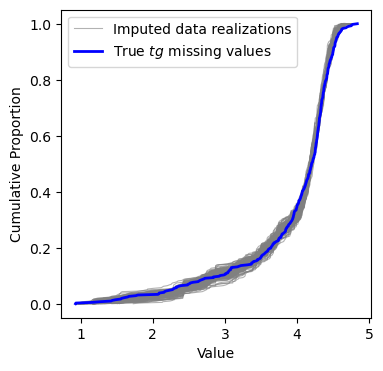

In [29]:
# Extract the columns
y_values_full = missing_set['var2'] # true values from missing dataset only

# Sort the true values for the target variable and compute its CDF
sorted_y_full = np.sort(y_values_full)
cdf_y_full = np.arange(1, len(sorted_y_full) + 1) / len(sorted_y_full)

# Plot true distribution as a CDF
plt.figure(figsize=(4, 4))

# Iterate through 'real_{i+1}' columns and plot their cumulative distributions
real_cols = [col for col in missing_set_orig.columns if col.startswith('real_')]
for i, col in enumerate(real_cols):
    sorted_real = np.sort(missing_set_orig[col])
    cdf_real = np.arange(1, len(sorted_real) + 1) / len(sorted_real)
    # Add label only to the first realization
    plt.plot(
        sorted_real, cdf_real,
        linestyle='-', color='grey', linewidth=0.8, alpha=0.6,
        label='Imputed data realizations' if i == 0 else None
    )

# Plot the CDF for the target variable
plt.plot(sorted_y_full, cdf_y_full, 
         label=r'True $\mathit{tg}$ missing values',  # only tg italic
         linestyle='-', color='b', linewidth=2)
    
# Add labels, title, and legend
plt.xlabel('Value')
plt.ylabel('Cumulative Proportion')
plt.legend(loc='upper left')  # Legend includes only 'w' and 'Realizations'
plt.grid(True, linestyle='--', alpha=0.001)

# Show the plot
plt.show()


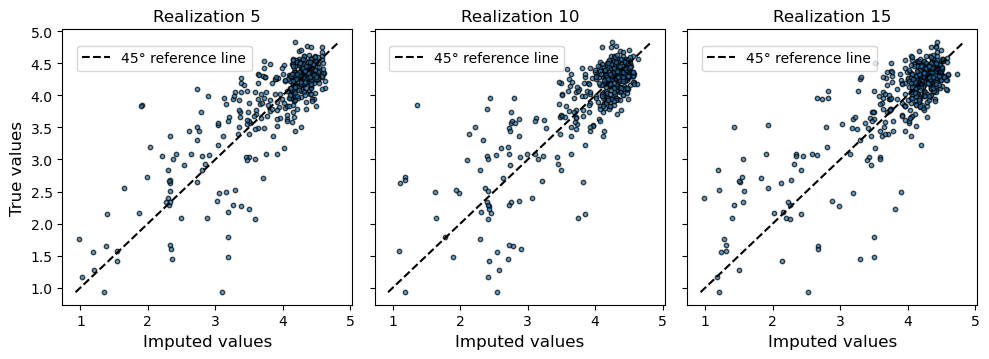

In [39]:
reference_values = missing_set_orig['var2'].values  # Reference values from the DataFrame

# Realizations you want to plot (5, 10, 15)
realizations_to_plot = [5, 10, 15]

# Set up the subplot grid
fig, axes = plt.subplots(1, 3, figsize=(10, 3.7), sharey=True)

# Loop through selected realizations and plot scatter plots
for ax, r in zip(axes, realizations_to_plot):

    ax.scatter(
        impute_realizations_orig[r, :],
        reference_values,
        alpha=0.7,
        s=10,
        edgecolor='k'
    )

    ax.plot(
        [reference_values.min(), reference_values.max()],
        [reference_values.min(), reference_values.max()],
        color='black', linestyle='--', label='45° reference line'
    )

    ax.set_title(f"Realization {r}", fontsize=12)
    ax.set_xlabel('Imputed values', fontsize=12)

# Y-label only on first subplot
axes[0].set_ylabel('True values', fontsize=12)

# Add legends
for ax in axes:
    ax.legend(loc=(0.05, 0.85), fontsize=10)

fig.tight_layout()
plt.show()


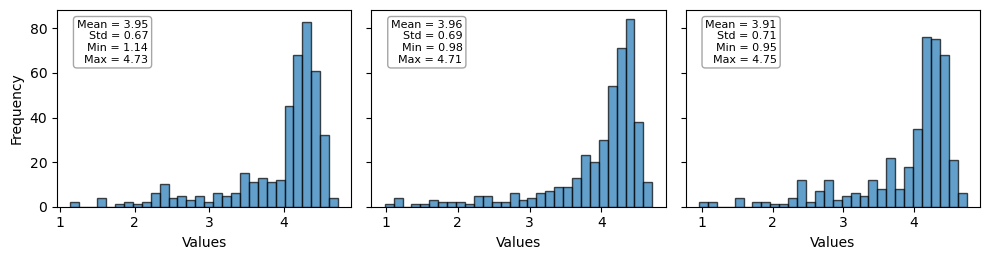

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

# Data for the first three realizations
realizations = [impute_realizations_orig[0, :], impute_realizations_orig[1, :], impute_realizations_orig[2, :]]

# Loop through the realizations and plot the histograms
for i, (realization, ax) in enumerate(zip(realizations, axes)):
    ax.hist(realization, bins=30, edgecolor='k', alpha=0.7)

    # Compute statistics
    mean_val = realization.mean()
    std_val = realization.std()
    min_val = realization.min()
    max_val = realization.max()

    # Annotate all statistics
    stats_text = (
        f"Mean = {mean_val:.2f}\n"
        f"Std = {std_val:.2f}\n"
        f"Min = {min_val:.2f}\n"
        f"Max = {max_val:.2f}"
    )

    ax.text(0.31, 0.95, stats_text,
            transform=ax.transAxes,
            fontsize=8,
            ha='right', va='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='gray', alpha=0.7))

    ax.set_xlabel('Values')
    if i == 0:
        ax.set_ylabel('Frequency')

# Adjust layout
fig.tight_layout()
# plt.suptitle('Histograms of the First Three Realizations', fontsize=14)
plt.subplots_adjust(top=0.85)

plt.show()


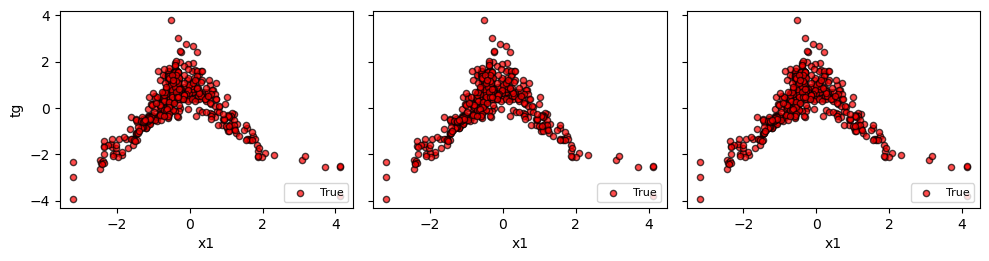

In [46]:
# Set up the subplot grid
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True, sharex=False)

# Titles for each subplot
# titles = [f'Realization {i + 1}' for i in range(3)]

# Loop through the first three realizations and plot scatter plots
for i, ax in enumerate(axes):
    
    # Plot true
    ax.scatter(missing_set['ns_var1'].values, missing_set['ns_var2'].values, color='red', alpha=0.7, s=20, edgecolor='k', label='True')

    # Plot simulations
#     ax.scatter(missing_set[var_x_ns].values, samples[i], alpha=0.4, s=10, label='Simulated values')   

    # Set titles and labels
#     ax.set_title(titles[i])
    ax.set_xlabel('x1')
    if i == 0:  # Add y-label to the first subplot
        ax.set_ylabel('tg')
    ax.legend(loc='lower right', fontsize=8)  # Add legend

# Adjust layout to prevent overlap
fig.tight_layout()
# plt.suptitle('Scatter Plots of the First Three Realizations', fontsize=14)
plt.subplots_adjust(top=0.85)  # Adjust space for the title

plt.show()

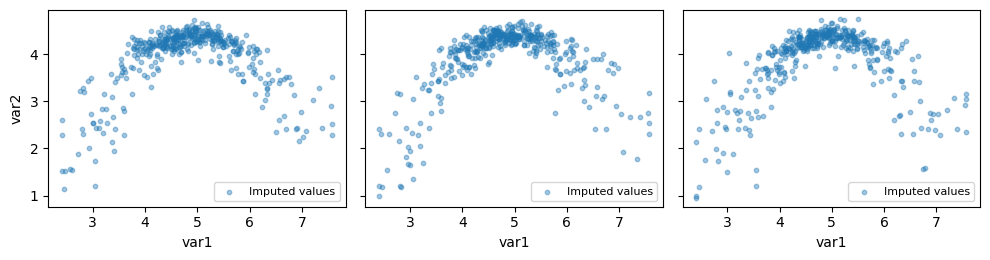

In [47]:
# Set up the subplot grid
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True, sharex=False)

# Titles for each subplot
titles = [f'Realization {i + 1}' for i in range(3)]

# Loop through the first three realizations and plot scatter plots
for i, ax in enumerate(axes):
    
    # Plot true
#     ax.scatter(dataset_with_samples[var_ref].values, dataset_with_samples[var_y].values, color='red', alpha=0.7, s=20, edgecolor='k', label='True')

    # Plot simulations
    ax.scatter(missing_set_orig['var1'].values, missing_set_orig[f'real_{1 + i}'], alpha=0.4, s=10, label='Imputed values')   

    # Set titles and labels
#     ax.set_title(titles[i])
    ax.set_xlabel('var1')
    if i == 0:  # Add y-label to the first subplot
        ax.set_ylabel('var2')
    ax.legend(loc='lower right', fontsize=8)  # Add legend

# Adjust layout to prevent overlap
fig.tight_layout()
# plt.suptitle('Scatter Plots of the First Three Realizations', fontsize=14)
plt.subplots_adjust(top=0.85)  # Adjust space for the title

plt.show()

Text(0, 0.5, '$\\mathit{tg}$ \n(realization 1)')

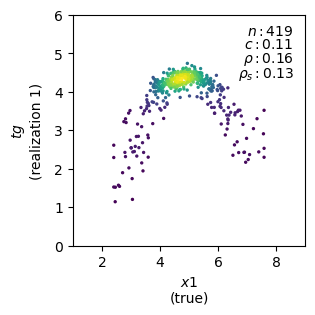

In [57]:
# Create the scatter plot matrix
real = 1
fig = missing_set_orig.scatplots([f'real_{real}', 'var1'], s=2, figsize=(3, 3), num_sample=1000, stats='all', stats_loc=(0.95,0.65))
plt.xlabel(r'$\mathit{x1}$' + ' \n(true)')
plt.ylabel(r'$\mathit{tg}$' + f' \n(realization {real})', rotation=90, labelpad=20)

Text(0, 0.5, '$\\mathit{tg}$ \n(true)')

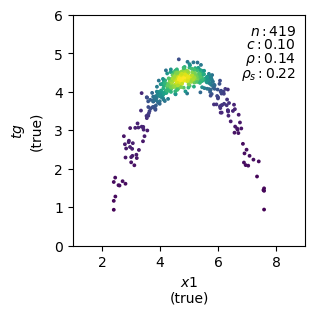

In [58]:
fig = missing_set_orig.scatplots(['var2', 'var1'], s=3, figsize=(3, 3), num_sample=1000, stats='all', stats_loc=(0.96,0.65))
plt.xlabel(r'$\mathit{x1}$' + ' \n(true)')
plt.ylabel(r'$\mathit{tg}$' + ' \n(true)', rotation=90, labelpad=20)

In [59]:
# Initialize SimCache in memory mode
cache = rmsp.SimCache(len(impute_realizations_orig_df))

# Store the DataFrame in cache
for i in range(1,n_real):
    cache.set_real(realidx=i, data=impute_realizations_orig_df.iloc[:, i], variables='var2')

In [60]:
# calculate accuracy
accuracy = rmsp.AccuracySim(missing_set_orig, 'var2', cache, 'var2')

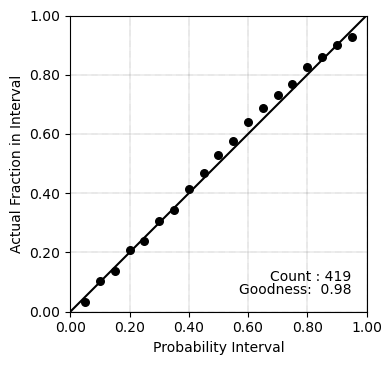

In [61]:
# plot accuracy
accuracy.plot(s=30, line_lw=0.01, grid=True, stats=['count', 'goodness'], figsize=(4,4))
plt.tight_layout()

# concatenate with original dataset

In [64]:
missing_set_orig

,x,y,var1,var2,real_1,real_2,real_3,real_4,real_5,real_6,...,real_91,real_92,real_93,real_94,real_95,real_96,real_97,real_98,real_99,real_100
1,10.0,1.0,3.541236,3.309053,3.786478,3.109744,1.196688,4.176460,1.770072,2.725398,...,3.338675,3.184437,2.542804,3.641672,3.167179,3.303303,2.797626,3.212274,3.186315,4.063135
2,20.0,1.0,2.452675,1.763755,1.137361,2.306651,1.188597,1.196859,1.465516,0.974974,...,1.178628,2.419530,1.019418,1.236141,1.518760,1.509322,2.331230,2.606841,2.323429,1.407350
5,50.0,1.0,5.091249,4.260121,4.673229,4.325903,4.346275,4.488487,4.406774,4.401677,...,4.437661,4.419721,4.145747,4.509843,4.420065,4.472832,4.491314,4.518290,4.377783,4.472041
6,60.0,1.0,5.555451,4.337155,4.181349,4.178112,4.442737,4.353205,3.847456,4.011447,...,4.409531,4.139269,3.723489,4.320316,4.036648,4.271118,4.345746,4.245560,4.105804,4.130671
8,80.0,1.0,5.610309,4.277357,3.956925,4.161419,4.102058,4.240657,4.037953,4.188092,...,4.103743,4.307445,4.245062,4.314836,4.109055,4.066710,4.191926,4.613432,4.367708,4.316807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,170.0,300.0,3.059212,2.658822,2.430058,1.356004,3.158527,1.532246,2.796624,2.309710,...,2.787009,2.454265,2.433769,2.594826,3.439976,1.524999,3.009321,3.106873,3.684084,2.727385
829,190.0,300.0,3.592878,3.597003,2.798164,3.073587,3.916033,3.639192,4.155803,3.192895,...,3.804216,4.022160,3.761410,4.029262,3.557303,3.641091,2.785418,2.786845,3.883371,2.812669
830,200.0,300.0,3.612507,3.437548,3.635163,3.733180,3.989194,2.870775,3.290000,2.760752,...,4.133894,3.551281,4.129289,2.708966,4.191556,3.721003,3.910800,3.193685,1.965185,4.344966
834,240.0,300.0,3.831457,3.841583,4.244602,4.171804,3.191738,3.626314,3.754888,4.093041,...,4.197425,4.036580,4.068185,3.287479,4.190186,4.036788,4.242469,3.559849,3.061524,3.845447


In [69]:
# Select `real_{i+1}` columns from `dataset_with_samples`
realizations = missing_set_orig.filter(like='real_')

# Reindex to match the original dataframe
realizations_full = realizations.reindex(data.index)

# Fill missing rows with the values from the original variable
for col in realizations_full.columns:
    realizations_full[col].fillna(data['var2'], inplace=True)
    
    # Add `real_{i+1}` columns back to the original dataset
data_filtered = data[['x', 'y', 'var1', 'var2']]
data_with_realizations = pd.concat([data_filtered, realizations_full], axis=1)

## check

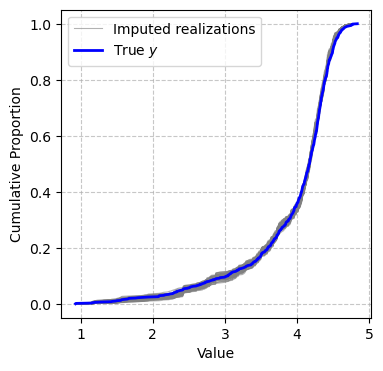

In [71]:
plt.figure(figsize=(4, 4))

# Extract the columns
y_values_full = data['var2'] # true reference values

# Sort the true values for the target variable and compute its CDF
sorted_y_full = np.sort(y_values_full)
cdf_y_full = np.arange(1, len(sorted_y_full) + 1) / len(sorted_y_full)


# Iterate through 'real_{i+1}' columns and plot their cumulative distributions
real_cols = [col for col in data_with_realizations.columns if col.startswith('real_')]
for i, col in enumerate(real_cols):
    sorted_real = np.sort(data_with_realizations[col])
    cdf_real = np.arange(1, len(sorted_real) + 1) / len(sorted_real)
    # Add label only to the first realization
    plt.plot(
        sorted_real, cdf_real,
        linestyle='-', color='grey', linewidth=0.8, alpha=0.6,
        label='Imputed realizations' if i == 0 else None
    )

# Plot the CDF for 'w'
plt.plot(sorted_y_full, cdf_y_full, label='True $\mathit{y}$', linestyle='-', color='b', linewidth=2)

# plt.plot(sorted_etype_full, cdf_etype_full, label=f'Mean realizations', linestyle='-', color='orange', linewidth=2)

    
# Add labels, title, and legend
# plt.title('Cumulative Distributions (full set)')
plt.xlabel('Value')
plt.ylabel('Cumulative Proportion')
plt.legend(loc='upper left')  # Legend includes only 'w' and 'Realizations'
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [84]:
# defining lags
lag = rmsp.Lags(10, 5, 15)

# defining searches for two directions
varsearches = [rmsp.ExpVarioSearch(157.0, 0.0, lag, azmtol=22, incltol=22.0, azmband=20, inclband=22),
                rmsp.ExpVarioSearch(67.0, 0.0, lag, azmtol=22, incltol=22.0, azmband=20, inclband=22)]

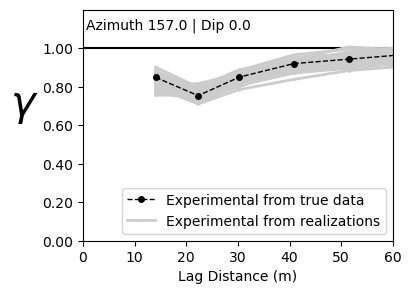

In [87]:
# defining funcion to calculate experimental variograms of the realizations from according to a specific direction 
def calc_vario(ireal):
    return rmsp.ExpVario().calculate(data_with_realizations, f'real_{ireal}', varsearches)

# calling up the function and applying it to the realizations
realvarios = rmsp.parallel_runner(
    calc_vario,
    [ireal for ireal in range(1, n_real)],
    progressbar=True,
)

# calculating the experimental variograms
expvario_true = rmsp.ExpVario('traditional').calculate(data, 'var2', varsearches)

# plotting the experimental variogram from the training set
_, ax = expvario_true.plot(azm=157.0, incl=0.0,
    ls="--", ms=4, c="black", label="Experimental from true data", zorder=100, figsize=(4, 3), search_index=0, pairs_bar=False, pairs_c='lightsteelblue', xlim=(0,60)
)

# plotting realizations
label = "__nolegend__" # label is defined as "__nolegend__", so we don't have the line of each and every realizations in the legend
for ireal, vario in enumerate(realvarios):
    if ireal == (n_real - 2):
        label = "Experimental from realizations" # this way we will have only one line in the legend, representing all realizations
    vario.plot_draw(ax, ls="-", lw=2, c=".8", ms=1, label=label, azm=157.0, incl=0.0) # plotting the experimental variogram of each realization

# plotting the experimental variogram from the training set
# varmodel.plot_draw(ax, label="Model", azm=157.0, incl=0.0, c='r', alpha=0.5)


# Adding explanatory text in the lower-left corner
plt.text(
    x=0.01, y=0.90,  # Position as a fraction of the axes (0.05 = 5% from left/bottom)
    s="Azimuth 157.0 | Dip 0.0",  # Explanatory text
    fontsize=10, color='black', ha='left', va='bottom', transform=plt.gca().transAxes
)

# adding legend
_ = ax.legend(loc=4)

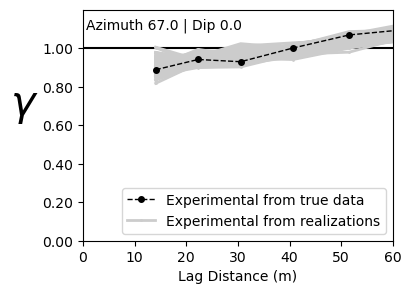

In [88]:
# defining funcion to calculate experimental variograms of the realizations from according to a specific direction 
def calc_vario(ireal):
    return rmsp.ExpVario().calculate(data_with_realizations, f'real_{ireal}', varsearches)

# calling up the function and applying it to the realizations
realvarios = rmsp.parallel_runner(
    calc_vario,
    [ireal for ireal in range(1, n_real)],
    progressbar=True,
)

# calculating the experimental variograms
expvario_true = rmsp.ExpVario('traditional').calculate(data, 'var2', varsearches)

# plotting the experimental variogram from the training set
_, ax = expvario_true.plot(azm=67.0, incl=0.0,
    ls="--", ms=4, c="black", label="Experimental from true data", zorder=100, figsize=(4, 3), search_index=1, pairs_bar=False, pairs_c='lightsteelblue', xlim=(0,60)
)

# plotting realizations
label = "__nolegend__" # label is defined as "__nolegend__", so we don't have the line of each and every realizations in the legend
for ireal, vario in enumerate(realvarios):
    if ireal == (n_real - 2):
        label = "Experimental from realizations" # this way we will have only one line in the legend, representing all realizations
    vario.plot_draw(ax, ls="-", lw=2, c=".8", ms=1, label=label, azm=67.0, incl=0.0) # plotting the experimental variogram of each realization

# plotting the experimental variogram from the training set
# varmodel.plot_draw(ax, label="Model", azm=157.0, incl=0.0, c='r', alpha=0.5)


# Adding explanatory text in the lower-left corner
plt.text(
    x=0.01, y=0.90,  # Position as a fraction of the axes (0.05 = 5% from left/bottom)
    s="Azimuth 67.0 | Dip 0.0",  # Explanatory text
    fontsize=10, color='black', ha='left', va='bottom', transform=plt.gca().transAxes
)

# adding legend
_ = ax.legend(loc=4)